In [1]:
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

In [2]:
# load the data
holders = pd.read_csv('cc_info.csv')
holders.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [3]:
holders.set_index('credit_card', inplace=True)
holders.rename(columns={'credit_card_limit': 'credit_limit'}, inplace=True)
holders.head()

,city,state,zipcode,credit_limit
credit_card,,,,
1280981422329509,Dallas,PA,18612,6000
9737219864179988,Houston,PA,15342,16000
4749889059323202,Auburn,MA,1501,14000
9591503562024072,Orlando,WV,26412,18000
2095640259001271,New York,NY,10001,20000


In [4]:
transactions = pd.read_csv('transactions.csv')
transactions.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [5]:
transactions.rename(columns={'transaction_dollar_amount':'amount'}, inplace=True)
transactions['date'] = pd.to_datetime(transactions['date'])
transactions.head()

,credit_card,date,amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [6]:
holders.describe()

,zipcode,credit_limit
count,984.000000,984.000000
mean,17895.316057,12321.138211
std,23778.651105,7398.449174
min,690.000000,2000.000000
25%,3280.000000,7000.000000
50%,5820.000000,10000.000000
75%,18101.250000,16000.000000
max,98401.000000,55000.000000


In [7]:
holders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 1280981422329509 to 1409322756311484
Data columns (total 4 columns):
city            984 non-null object
state           984 non-null object
zipcode         984 non-null int64
credit_limit    984 non-null int64
dtypes: int64(2), object(2)
memory usage: 38.4+ KB


In [8]:
transactions.describe()

,credit_card,amount,Long,Lat
count,2.945880e+05,294588.000000,294588.000000,294588.000000
mean,5.424562e+15,86.008036,-76.235238,40.937669
std,2.555803e+15,124.655954,20.135015,5.391695
min,1.003715e+15,0.010000,-179.392887,-68.046553
25%,3.344214e+15,29.970000,-80.209708,40.487726
50%,5.353426e+15,58.470000,-73.199737,42.403066
75%,7.646245e+15,100.400000,-72.091933,43.180015
max,9.999757e+15,999.970000,179.917513,78.914330


In [9]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card    294588 non-null int64
date           294588 non-null datetime64[ns]
amount         294588 non-null float64
Long           294588 non-null float64
Lat            294588 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 11.2 MB


In [10]:
# Answer 1

In [11]:
transactions['date'].dt.year.value_counts()

2015    294588
Name: date, dtype: int64

In [12]:
transactions['date'].dt.month.value_counts()

8     99167
9     96026
10    95014
7      4381
Name: date, dtype: int64

In [13]:
# calculate each user's monthly spending
# Only one year 2015. 
def user_monthly_spent(df):
    return df.groupby(df['date'].dt.month)['amount'].agg('sum')

In [14]:
# group by users (i.e, card number)
# and calculate monthly spent
card_monthly_spent = transactions.groupby('credit_card').apply(user_monthly_spent).unstack(fill_value=0)

In [15]:
card_monthly_spent = card_monthly_spent.join(holders['credit_limit'])
card_monthly_spent.head()

,7,8,9,10,credit_limit
credit_card,,,,,
1003715054175576,162.56,8441.51,11281.56,8954.21,20000
1013870087888817,281.43,11981.15,12461.96,12090.34,15000
1023820165155391,943.26,22741.20,18108.12,19259.98,28000
1073931538936472,220.07,2991.05,2557.12,1638.03,10000
1077622576192810,0.00,634.61,551.28,604.84,10000


In [16]:
n_months = card_monthly_spent.shape[1]-1

def never_above_limit(s):
    limit = s.loc['credit_limit']
    return (s.iloc[0:n_months] <= limit).all() # return true if the user didn't exceed limit in any months

In [17]:
is_user_never_exceed_limit = card_monthly_spent.apply(never_above_limit, axis=1)
users_never_exceeded_limit = card_monthly_spent.loc[is_user_never_exceed_limit, :].index

In [18]:
users_never_exceeded_limit

Int64Index([1003715054175576, 1013870087888817, 1023820165155391,
            1073931538936472, 1077622576192810, 1087468642191606,
            1089479586475600, 1101164752077181, 1107936587129946,
            1126571863414211,
            ...
            9854872265114976, 9855217884613002, 9867492085978660,
            9884182241594028, 9938969980242308, 9946917923319410,
            9958678964376192, 9961694231875562, 9981251982982618,
            9986135779184360],
           dtype='int64', name=u'credit_card', length=862)

In [19]:
with open("user_id_never_exceeded_limit", "wt") as outf:
    for ids in users_never_exceeded_limit:
        outf.write('{}\n'.format(ids))

In [20]:
# answer 2

In [21]:
class MonthlySpendingMonitor(object):
    
    def __init__(self, credit_limits):
        """
        card limit is a dictionary
        key: card number(cardno), value: credit limit
        """
        self.credit_limits = credit_limits
        self.total_spent = defaultdict(float)
        
    def reset(self):
        self.total_spent.clear()
        
    def count(self, daily_transactions):
        """
        daily_transactions is a dictionary
        key: cardno, value: amount spent
        """
        for cardno, amount in daily_transactions:
            self.total_spent[cardno] += amount
            
        return [cardno for cardno, total in self.total_spent.viewitems() if total > self.credit_limits[cardno]]

In [22]:
# answer 3
# unsupervised algorithms to detect frauds

In [23]:
# def stats_by_card(s):
#     ps = [25,50,75]
#     percentiles = np.percentile(s,ps)
#     return pd.Series(percentiles, index=['{}%'.format(p) for p in ps])

In [24]:
# trans_stats = transactions.groupby('credit_card')['amount'].apply(stats_by_card).unstack()
# trans_stats.head()

,25%,50%,75%
credit_card,,,
1003715054175576,59.01,93.73,124.63
1013870087888817,58.09,87.67,128.02
1023820165155391,55.43,85.78,122.83
1073931538936472,108.08,147.19,194.83
1077622576192810,122.93,148.18,160.11


In [25]:
# # merge transactions with previous consumption stats
# temp = pd.merge(transactions, trans_stats, how='left', left_on='credit_card', right_index=True)

# # merge with credit card limit
# transactions = pd.merge(temp,holders.loc[:,['credit_limit']],how='left',left_on='credit_card',right_index=True)
# transactions.tail()

,credit_card,date,amount,Long,Lat,25%,50%,75%,credit_limit
294583,9999757432802760,2015-09-10 19:43:33,127.23,-82.360952,32.978497,83.74,130.94,177.905,6000
294584,9999757432802760,2015-08-06 21:00:13,84.90,-82.322721,33.061071,83.74,130.94,177.905,6000
294585,9999757432802760,2015-09-22 16:15:47,77.54,-82.442130,32.949983,83.74,130.94,177.905,6000
294586,9999757432802760,2015-08-27 18:08:24,144.05,-82.398587,32.976162,83.74,130.94,177.905,6000
294587,9999757432802760,2015-08-22 00:14:52,154.36,-82.389680,33.068351,83.74,130.94,177.905,6000


In [26]:
# # keep the relevant features
# X = transactions.loc[:, ['amount', '25%', '50%', '75%', 'credit_limit']]
# X.head()

,amount,25%,50%,75%,credit_limit
0,43.78,59.01,93.73,124.63,20000
1,103.15,59.01,93.73,124.63,20000
2,48.55,59.01,93.73,124.63,20000
3,136.18,59.01,93.73,124.63,20000
4,71.82,59.01,93.73,124.63,20000


In [27]:
# X.describe()

,amount,25%,50%,75%,credit_limit
count,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,86.008036,43.265113,69.081697,97.282645,15502.053716
std,124.655954,21.471896,35.160028,49.919646,7956.291556
min,0.010000,6.150000,7.320000,9.120000,2000.000000
25%,29.970000,27.960000,43.590000,60.812500,10000.000000
50%,58.470000,40.595000,65.190000,91.832500,15000.000000
75%,100.400000,56.215000,89.710000,127.345000,20000.000000
max,999.970000,137.690000,222.290000,318.730000,55000.000000


In [29]:
# reduce X to 2D to get some hint. 
# credit card limit has much higher variance. 
# scale all features to unit variance before applying PCA. if not
# pca will be highly aligned towards credit_limit
# X = scale(X)

In [35]:
# # use pca to reduce feature matrix to 2D
# pca = PCA(n_components=2)
# X2d = pca.fit_transform(X)
# X2d = pd.DataFrame(X2d, columns=['pc1', 'pc2'])
# X2d.head()

,pc1,pc2
0,1.184559,-0.583757
1,1.277856,-0.117918
2,1.192055,-0.546330
3,1.329760,0.141247
4,1.228622,-0.363745


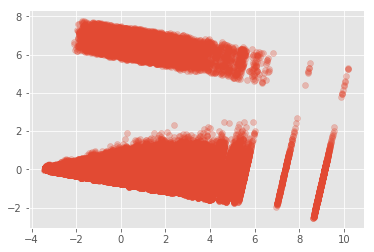

In [39]:
# plt.scatter(X2d['pc1'], X2d['pc2'], alpha=0.3)

In [40]:
# n_clusters = 6
# kmeans = KMeans(n_clusters=n_clusters,n_jobs=-1)
# kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [41]:
# X2d['label'] = kmeans.labels_
# print X2d.label.value_counts()

3    107634
4     73476
5     49133
0     33069
1     25840
2      5436
Name: label, dtype: int64


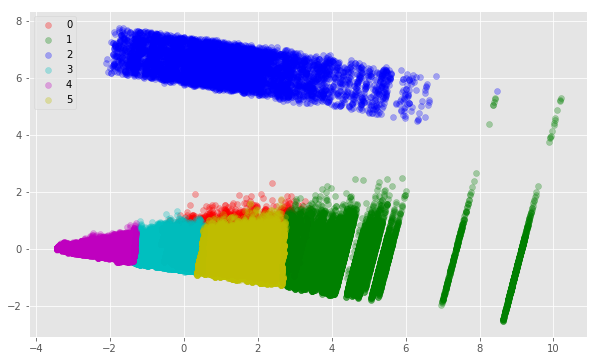

In [42]:
# colors = itertools.cycle( ['r','g','b','c','m','y','k'] )

# plt.rc('figure',figsize=(10,6))
# for label in  xrange(n_clusters) :
#     temp = X2d.loc[X2d.label == label,:]
#     plt.scatter(temp.pc1,temp.pc2,c=next(colors),label=label,alpha=0.3)

# plt.legend(loc='best')

In [43]:
# X2d.head()

,pc1,pc2,label
0,1.184559,-0.583757,5
1,1.277856,-0.117918,5
2,1.192055,-0.546330,5
3,1.329760,0.141247,5
4,1.228622,-0.363745,5


In [48]:
# suspicious_label = X2d.label.value_counts().argmin()
# suspicious_label

2

In [45]:
# suspect = transactions.loc[X2d.label==suspicious_label,['credit_card','amount','25%','50%','75%','credit_limit','date']]
# suspect.to_csv('suspect.csv',index=False)

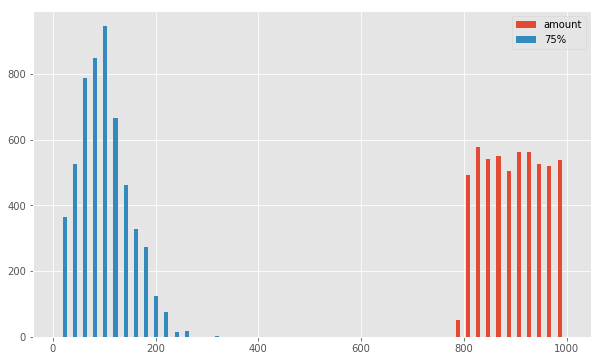

In [46]:
# labels = ["amount",'75%']
# plt.hist(suspect.loc[:,labels].values,bins=50,label=labels)
# plt.legend(loc='best')